In [22]:
import os
from dotenv import load_dotenv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
base_path = os.getenv("BASE_LOCAL_DIR_PATH")

df_data_org = pd.read_json(f"{base_path}project_notebook/collaborative_filtering/data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


## Descriptions
### definitions of each columns
|column|description|type|
|---|---|---|
|id|id of transactions made when item is provided|int|
|user_id|id of user|int|
|item_id|id of provided item|int|
|join|when user select provided item then 1, else 0|bool|

In [2]:
print(f"user_id counts: {df_data_org.user_id.nunique()}")
print(f"item_id counts: {df_data_org.item_id.nunique()}")


user_id counts: 70
item_id counts: 1954


In [3]:
print(f"provided counts: {df_data_org.id.nunique()}")
print(f"selection count: {df_data_org['join'].sum()}")
print(f"selection ratio: {round(df_data_org['join'].sum() / df_data_org.id.nunique(),4)*100} %")

provided counts: 95993
selection count: 5346
selection ratio: 5.57 %


## Main Goal
- Business Strategy 상 공급 대비 수요 과잉 상태 진단으로, 과잉된 수요 상태에서 **유효 수효 창출**을 위한 `추천 및 개인화` 가능성 탐색
- `User` & `Item` 들을 Clustering할 수 있는 basic standard 탐색


### Back Ground
- **쉽고, 빠른** 알고리즘으로 pre-test 진행해 가능성 검증 시도
- `User`에게 선호할 확률이 높은 미경험 `Item` 제공을 촉진하기 위해, **User와 item간의 패턴 및 특이성을 파악**.
- 제한된 데이터셋 및 명시적 평점 데이터의 부존

### Defination of problems to solve
1. `User`와 `Item`간의 상호 선호 정의 및 탐색
2. 각 그룹별 선호를 기준으로 Clustering
3. `User`의 `Item` 선택 확률에 대한 예측 가능성 탐색

### Brain storming for solutions
1. 암묵적 평점 데이터 기반 `User`의 `Item`에 대한 선호 정의
    > 암묵적 평점 데이터는 Item별 경험 대비 선택율
2. cosine similarity, euclidean distance, pearson correlation 등 기초 유사도 계산식 기반 EDA
    > if. 특정 패턴 발견하지 못할 경우, 그룹별 Clurstering 진행하지 않거나 SVD, ALS 알고리즘 적용 시도.
3. 주어진 test.json 이후 생성된 데이터들을 기준으로 validation 진행


In [4]:
# make score data 
df_data = df_data_org.copy()

def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    res['reject_cnt'] = res['apply_cnt'] - res['join_cnt']
    res['ratio'] = res['join_cnt'] / res['apply_cnt']
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)
df_grouped.head()


,user_id,item_id,apply_cnt,join_cnt,reject_cnt,ratio
0,0,0,3.0,0.0,3.0,0.000
1,0,1,3.0,0.0,3.0,0.000
2,0,2,2.0,1.0,1.0,0.500
3,0,3,8.0,1.0,7.0,0.125
4,0,7,5.0,1.0,4.0,0.200


<AxesSubplot: >

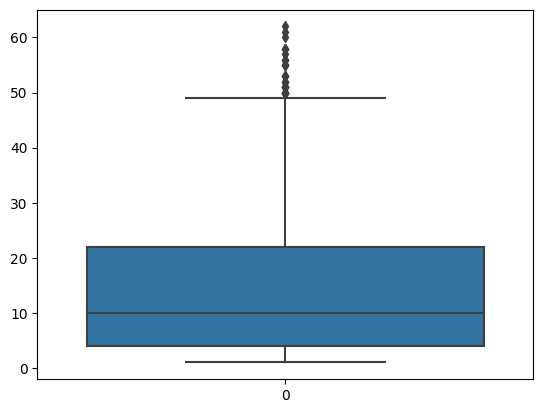

In [23]:
df_items = df_data[['item_id', 'user_id']].groupby(['item_id']).nunique().reset_index()
sns.boxplot(df_items['user_id'])

In [6]:
# filtering items where provided count >10
sample_items = list(df_items.loc[df_items['user_id']>10, "item_id"])
df_grouped = df_grouped.loc[df_grouped['item_id'].isin(sample_items)]

## EDA

### 1. cosine similarity & euclidean distance
| `User` 간 동일-경험 집합에서 각각 선택 집합과 집합 내 요소 각각의 선정 확률을 기준으로 `User`간 유사도 측정이 가능할까?

- $set(A)$: user A가 경험한 item의 전체 집합
- $set(B)$: user B가 경험한 item의 전체 집합
- $set(A) \bigcap\ set(B)$: user A & user B 모두 경험한 item 집합
- $P(A)$: user A가 경험한 item들에 대한 선택 확률 집합
- $set(A) \bigcap\ set(B)$ 에서 동일 선택 항목을 바탕으로 `cosine similarity` 적용
- $set(A) \bigcap\ set(B)$ 에서 항목별 선택확률을 바탕으로 `euclidean distance` 적용

#### *Cosine Similarity*

In [7]:
def make_group_cos(value):
    res = dict()
    data = value.to_dict(orient='records')
    for row in data:
        res[row['item_id']] = row['ratio']
    return res

cos_records = df_grouped.groupby('user_id').apply(make_group_cos)
cos_records = cos_records.to_dict()

In [13]:
def get_cosine_similarity(target:dict, check:dict):
    target = {  
        key:value
        for key, value in target.items()
        if value >0 
    }
    check = {  
        key:value
        for key, value in check.items()
        if value >0 
    }
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    if len(intersection_items) == 0:
        return 0
    list_target = [target.get(idx) - 0.5 for idx in intersection_items]
    list_check = [check.get(idx) - 0.5 for idx in intersection_items]
    if np.linalg.norm(list_target)*np.linalg.norm(list_check) == 0:
        return 0
    res_value = np.dot(list_target,list_check)/(np.linalg.norm(list_target)*np.linalg.norm(list_check))
    return round(res_value, 4)


<AxesSubplot: >

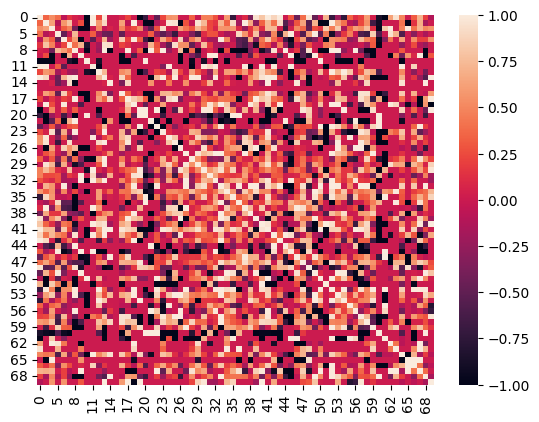

In [14]:
res_cos = dict()
for target_idx, target_user in cos_records.items():
    check_data =dict()
    for check_idx, check_user in cos_records.items():
        check_data[check_idx] = get_cosine_similarity(target_user, check_user)
    res_cos[target_idx] = check_data

df_cos = pd.DataFrame(res_cos)
sns.heatmap(df_cos)

#### *Euclidean Distance*

In [15]:
def make_group_euc(value):
    return dict(zip(value['item_id'], value['score']))

euc_records = df_grouped.copy()
euc_records['score'] = euc_records['join_cnt'] - euc_records['reject_cnt']

euc_records = euc_records.groupby(by='user_id').apply(make_group_euc)

In [16]:
def get_euclidean(target:dict, check:dict):
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    if intersection_items == None:
        return None
    list_target = [target.get(idx) for idx in intersection_items]
    list_check = [check.get(idx) for idx in intersection_items]
    return np.linalg.norm(np.array(list_target) - np.array(list_check))

<AxesSubplot: >

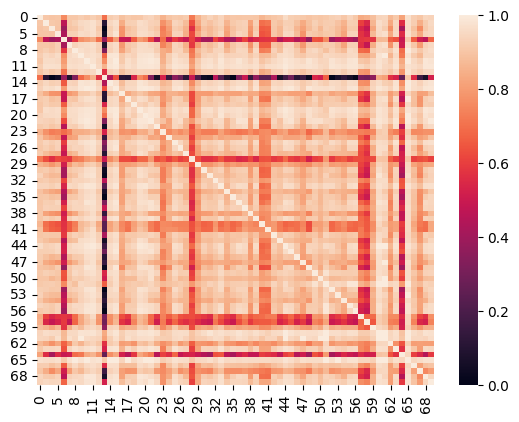

In [17]:
res_euc = dict()
for target_idx in euc_records.keys():
    res_euc_check = dict()
    for check_idx in euc_records.keys():
        res_euc_check[check_idx] = get_euclidean(euc_records[target_idx], euc_records[check_idx])
    res_euc[target_idx] = res_euc_check

df_euc = pd.DataFrame(res_euc)

# apply scaler to df
# transform score to range between 0 and 1 and make reverse array
max_num = df_euc.max().max()
min_num = df_euc.min().min()
df_euc = df_euc.loc[:,:].apply(lambda x: 1-((x-min_num)/(max_num-min_num)))

sns.heatmap(df_euc)

#### *Check data using Scatter Plot*

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_26203/3853483109.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for index_, idx in enumerate(df_cos[target].sort_values(ascending=False)[1:10].keys()):


Text(0.5, 0.98, 'Target is 0')

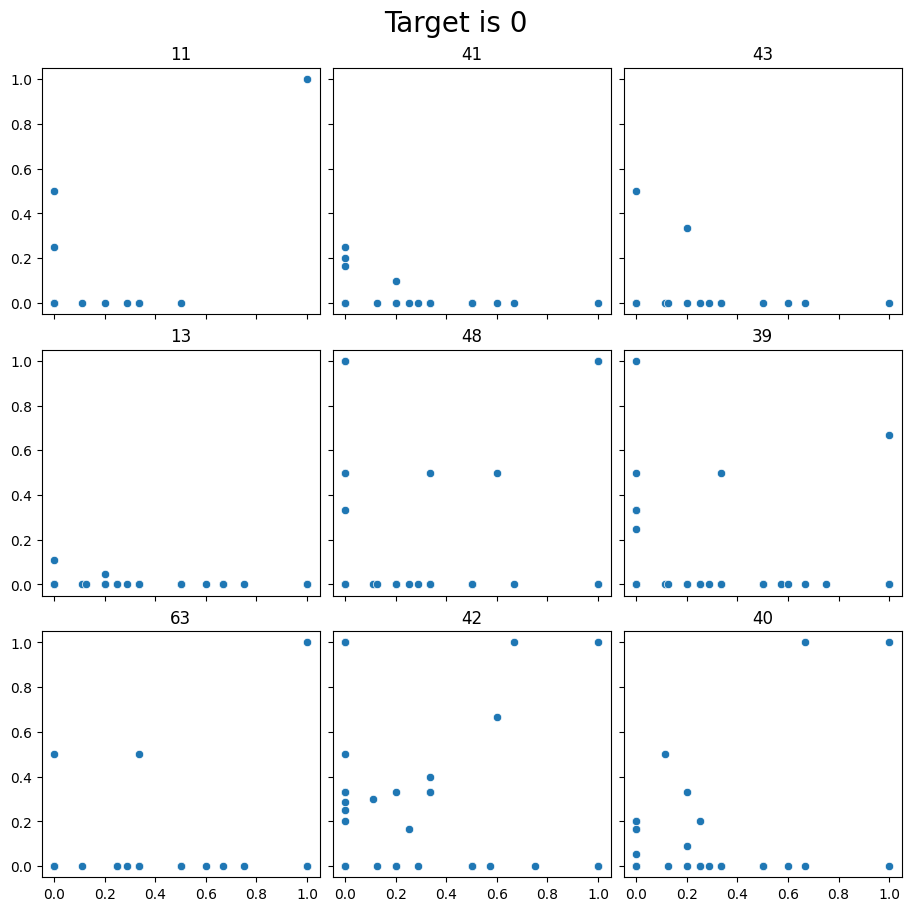

In [18]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
target = 0
for index_, idx in enumerate(df_cos[target].sort_values(ascending=False)[1:10].keys()): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx,
    ).set(title=idx, ylabel=None, xlabel=None)

fig.suptitle(f"Target is {target}", fontsize=20)

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_26203/703256993.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for index_, idx in enumerate(df_euc[target].sort_values(ascending=False)[1:10].keys()):


Text(0.5, 0.98, 'Target is 0')

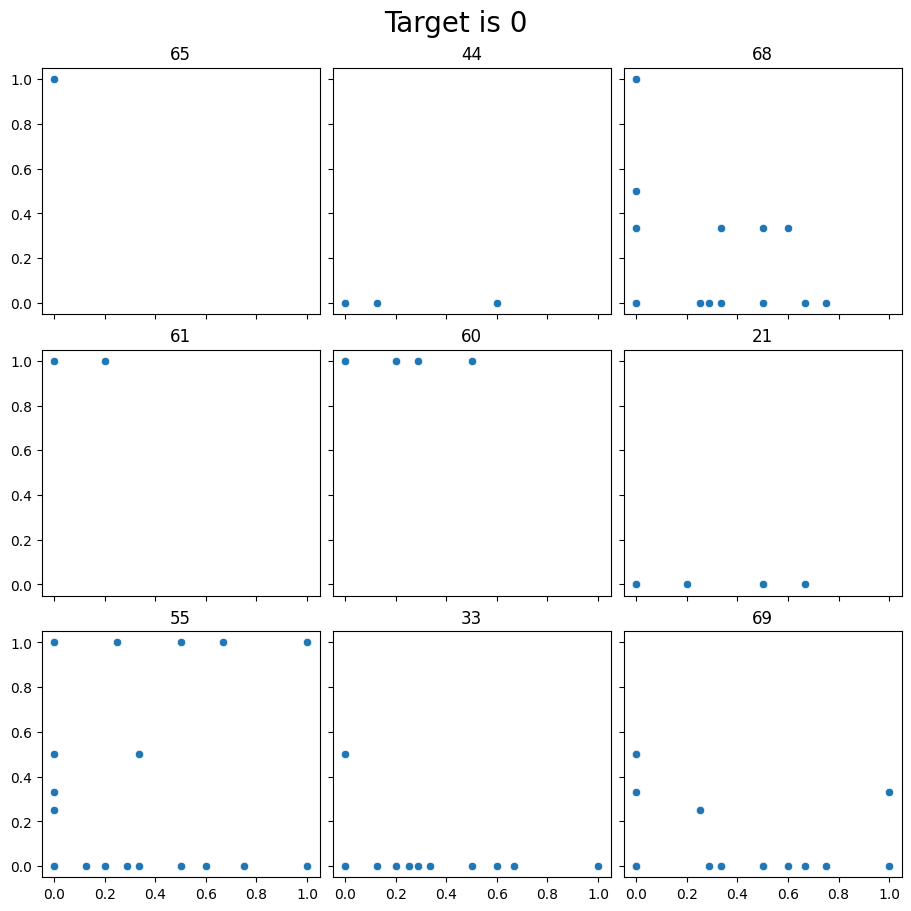

In [19]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
target = 0
for index_, idx in enumerate(df_euc[target].sort_values(ascending=False)[1:10].keys()): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx,
    ).set(title=idx, ylabel=None, xlabel=None)

fig.suptitle(f"Target is {target}", fontsize=20)

In [20]:
# combine df_cos & df_euc
index_to_id = {index_:idx for index_, idx in enumerate(df_cos.index)}
result = (np.array(df_cos) + np.array(df_euc))/2


Text(0.5, 0.98, 'Target is 0')

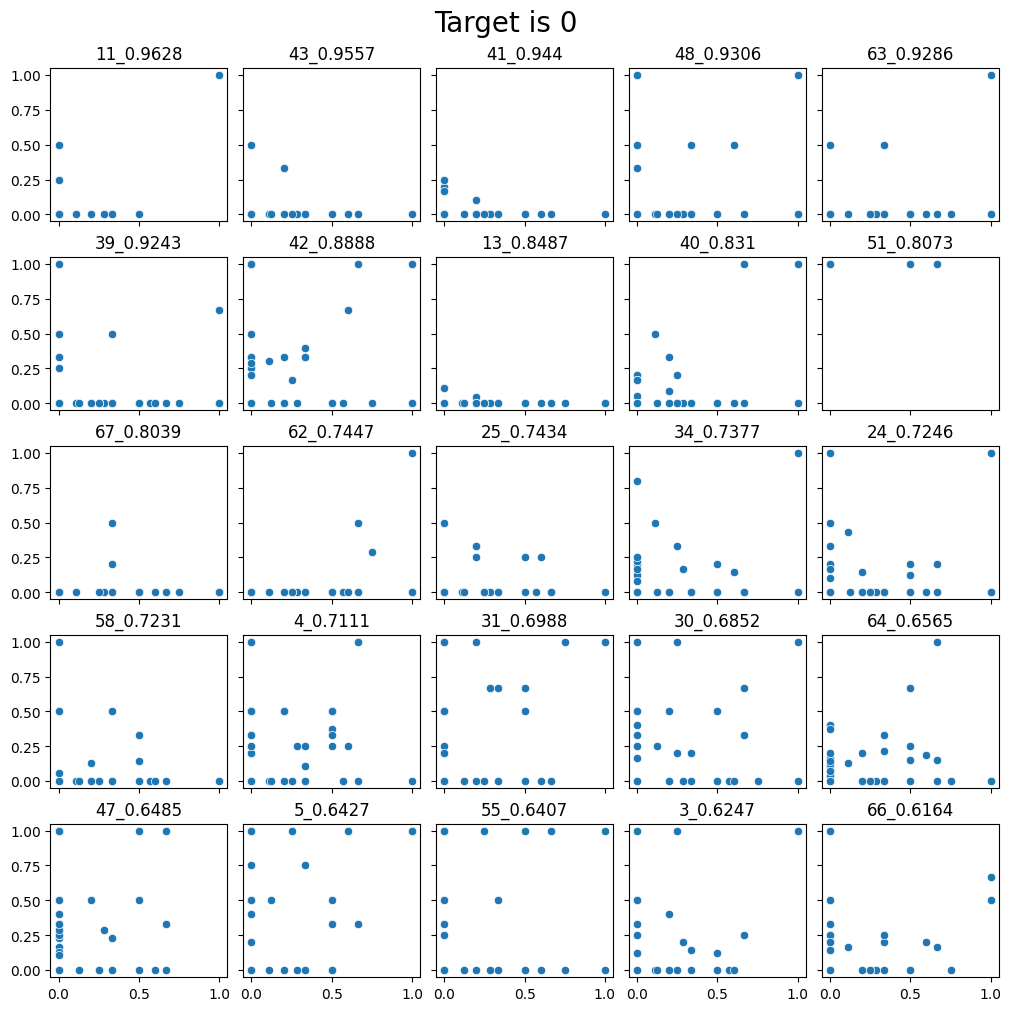

In [21]:
show_num = 5
fig, axes = plt.subplots(show_num,show_num, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)
target = 0

tlst = [(index_, value) for index_, value in enumerate(result[0])]
tlst.sort(key=lambda x: x[1], reverse=True)
tlst

plt_num = 0
for index_, idx in tlst[1:show_num*show_num+1]:
    sns.scatterplot(
        ax= axes[plt_num//show_num, plt_num%show_num],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,index_to_id[index_]])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=index_to_id[index_],
    ).set(title=f"{index_to_id[index_]}_{round(idx,4)}", ylabel=None, xlabel=None)
    plt_num += 1

fig.suptitle(f"Target is {target}", fontsize=20)

### 2. correlations of Pearson and Spearman
| cosine similarity & euclidean distance 기반의 user별 유사도 기준 Clurstering에 특징점 파악 X <br>
| 고도화 보다, 다른 시각의 분석 접목

> user별로 경험한 item별 선택 확률 기준 Correlation 산출

- **Pearson**
    - user별 item별 선택 확률에 대한 상관계수 계산
    - $X$축에는 `user_1`, $Y$축에는 `user_2`를 가지는 2차원 평면에서 두 `user`의 item별 선택 확률간 상관관계 탐색
    - 이 때, 하나의 0확률을 가지는 item은 상관계수 산출식에서 제외
- **Sperman**
    - user별 상위 $N$개의 item 순위를 매기고, 해당 순위 간 상관계수를 계산

In [24]:
df_items = df_data_org[['item_id', 'user_id']].groupby('item_id').nunique().reset_index()
# Find items where provided count is over than 10
list_item = list(df_items.loc[df_items['user_id']>10, ['item_id']]['item_id'])

df_data = df_data_org.loc[df_data_org['item_id'].isin(list_item)].copy()

def get_agg(value):
    return pd.Series({"ratio":value['join'].sum() / value['id'].count()}, index=['ratio'])

df_grouped_2 = df_data.groupby(['user_id', 'item_id']).apply(get_agg)
df_grouped_2.reset_index(inplace=True)
df_grouped_2.head(10)


,user_id,item_id,ratio
0,0,7,0.200000
1,0,8,0.000000
2,0,10,0.000000
3,0,11,0.750000
4,0,13,0.500000
5,0,16,0.285714
6,0,19,0.000000
7,0,20,0.250000
8,0,30,0.000000
9,0,33,0.000000


#### *Pearson*

<AxesSubplot: xlabel='user_id', ylabel='user_id'>

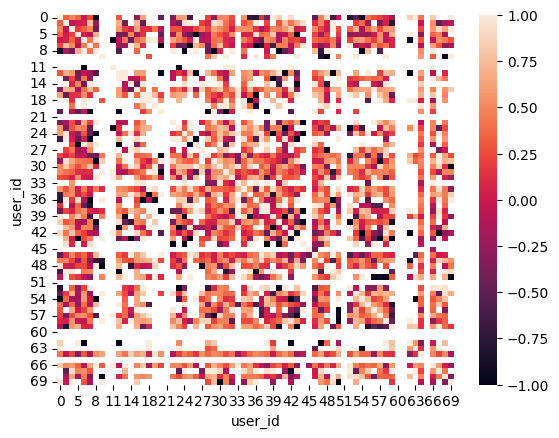

In [27]:
pcc = df_grouped_2.loc[df_grouped_2['ratio']>0].pivot(index='item_id', columns='user_id', values='ratio')
pcc_matrix = pcc.corr(method='pearson')
sns.heatmap(pcc_matrix)

In [69]:
valid_user = [idx for idx in pcc_matrix.index if sum(pcc_matrix[idx].notna())>30]
len(valid_user)


47

<AxesSubplot: xlabel='user_id', ylabel='user_id'>

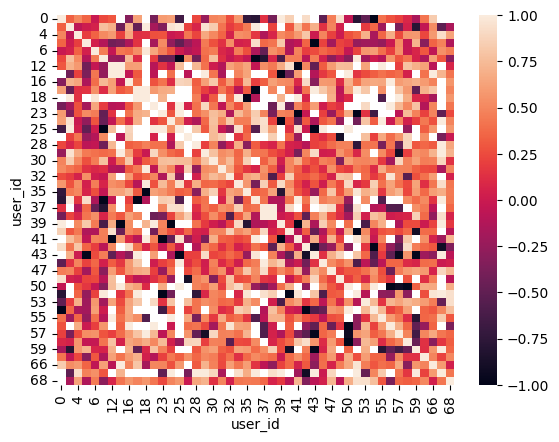

In [70]:
sns.heatmap(pcc_matrix.loc[pcc_matrix.index.isin(valid_user), valid_user])

In [81]:
df_test = pcc_matrix.loc[pcc_matrix.index.isin(valid_user), valid_user]
df_test.head()

user_id,0,3,4,5,6,7,12,13,16,17,...,54,55,56,57,58,59,64,66,67,68
user_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.332209,0.499728,0.350146,-0.009525,0.235204,0.290152,NaN,-0.321005,0.623578,...,-1.000000,0.406250,2.773501e-01,0.204406,0.080262,-0.170322,0.415568,0.829449,NaN,NaN
3,0.332209,1.000000,-0.066864,0.015495,0.053591,0.769128,0.691020,-0.425108,0.707677,-0.468963,...,0.364032,-0.204244,NaN,-0.376994,0.049123,-0.791130,-0.040398,0.526618,-0.508559,-0.154181
4,0.499728,-0.066864,1.000000,0.189220,0.341682,0.509300,0.585836,0.205352,0.642381,0.131096,...,-0.161508,0.354143,6.756972e-01,0.247665,0.577587,0.580743,0.226724,0.580605,0.927686,0.631381
5,0.350146,0.015495,0.189220,1.000000,0.044703,-0.110249,-0.420491,-0.370393,-0.148059,0.142349,...,-0.193350,-0.256776,-2.884444e-16,0.524659,-0.037668,0.706519,-0.313647,0.345111,0.469095,-0.137586
6,-0.009525,0.053591,0.341682,0.044703,1.000000,0.451855,-0.037302,0.427386,0.390570,0.536111,...,0.605037,0.391922,1.985182e-01,0.551152,-0.031033,0.073296,0.292760,-0.062137,0.546671,0.450977


Text(0.5, 0.98, 'Target is 55')

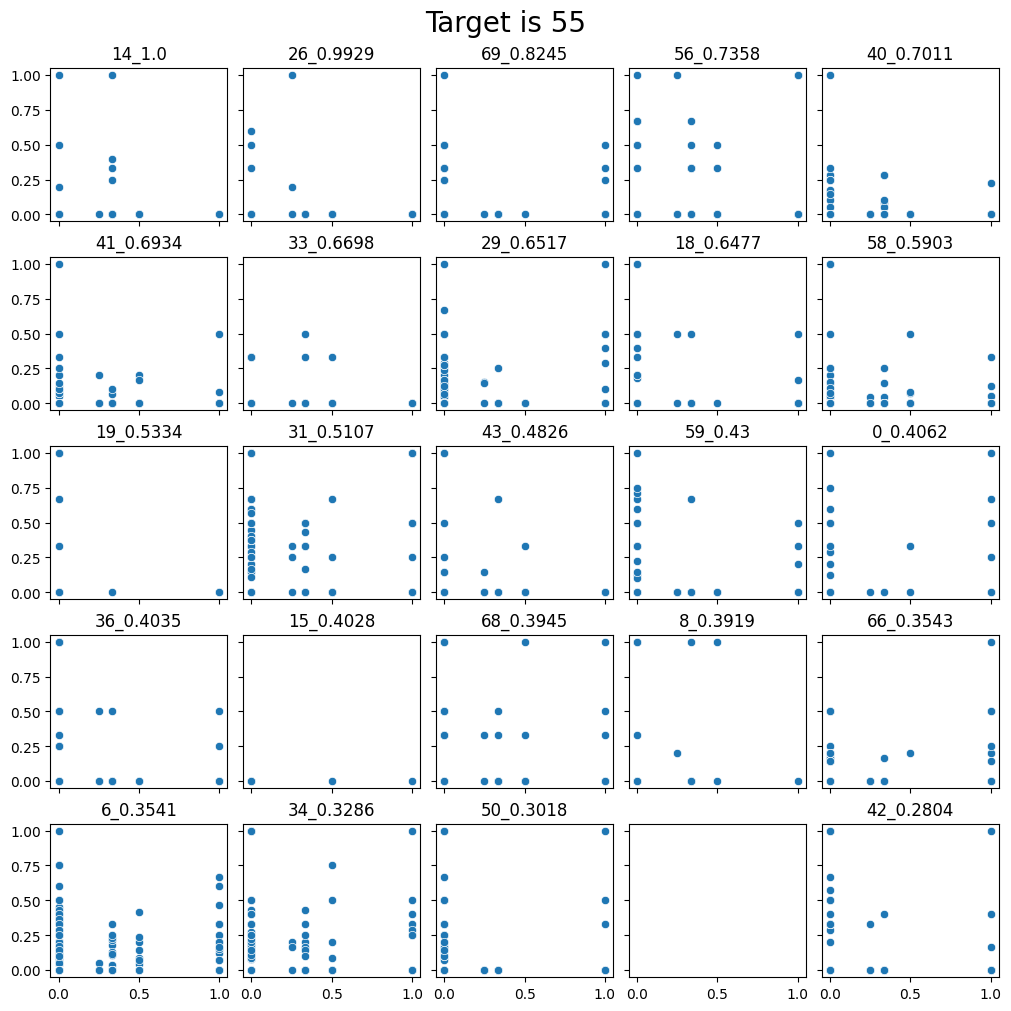

In [85]:
show_num = 5
fig, axes = plt.subplots(show_num,show_num, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)
target = 55

tlst = df_test[target].sort_values(ascending=False)
tlst = [(key, value) for key, value in tlst.items()]

plt_num = 0
for index_, idx in tlst[1:show_num*show_num+1]:
    try:
        sns.scatterplot(
            ax= axes[plt_num//show_num, plt_num%show_num],
            data=df_grouped_2.loc[df_grouped_2['user_id'].isin([target,index_to_id[index_]])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
            x=target,
            y=index_to_id[index_],
        ).set(title=f"{index_to_id[index_]}_{round(idx,4)}", ylabel=None, xlabel=None)
    except Exception:
        pass
    plt_num += 1

fig.suptitle(f"Target is {target}", fontsize=20)

#### Spearman

In [92]:
df_grouped_2
for idx in df_grouped_2['user_id'].unique():
    df_grouped_2.loc[df_grouped_2['user_id']==idx, 'rank'] = df_grouped_2.loc[df_grouped_2['user_id']==idx, ['item_id', 'ratio']]


,user_id,item_id,ratio
0,0,7,0.20
1,0,8,0.00
2,0,10,0.00
3,0,11,0.75
4,0,13,0.50
...,...,...,...
24029,69,1826,0.00
24030,69,1828,0.40
24031,69,1837,0.00
24032,69,1838,0.00


In [131]:
for idx in df_grouped_2.user_id.unique():
    df_grouped_2.loc[df_grouped_2['user_id']==idx, "rank"] = df_grouped_2.loc[df_grouped_2['user_id']==idx, "ratio"].rank(method='dense', ascending=False)

# 선택 확률이 0인 건들에 대한 rank penalty 적용
df_grouped_2.loc[df_grouped_2['ratio']==0, 'rank'] = 9999
df_grouped_2

,user_id,item_id,ratio,rank
0,0,7,0.20,10.0
1,0,8,0.00,9999.0
2,0,10,0.00,9999.0
3,0,11,0.75,2.0
4,0,13,0.50,6.0
...,...,...,...,...
24029,69,1826,0.00,9999.0
24030,69,1828,0.40,3.0
24031,69,1837,0.00,9999.0
24032,69,1838,0.00,9999.0


<AxesSubplot: xlabel='user_id', ylabel='user_id'>

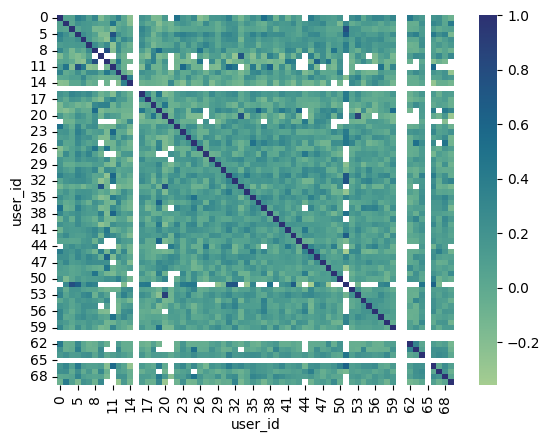

In [132]:
scc_matrix = df_grouped_2.pivot(index='item_id', columns='user_id', values='rank').corr(method='spearman')
sns.heatmap(scc_matrix, cmap="crest")

In [133]:
scc_matrix[0].sort_values(ascending=False)[1:10]

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_26203/3558778753.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  scc_matrix[0].sort_values(ascending=False)[1:10]


user_id
37    0.511792
22    0.487631
62    0.420829
45    0.405776
5     0.376839
31    0.349552
12    0.347363
53    0.327314
38    0.310569
Name: 0, dtype: float64

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_26203/1154941586.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for index_, idx in tlst[1:show_num*show_num+1].items():


Text(0.5, 0.98, 'Target is 0')

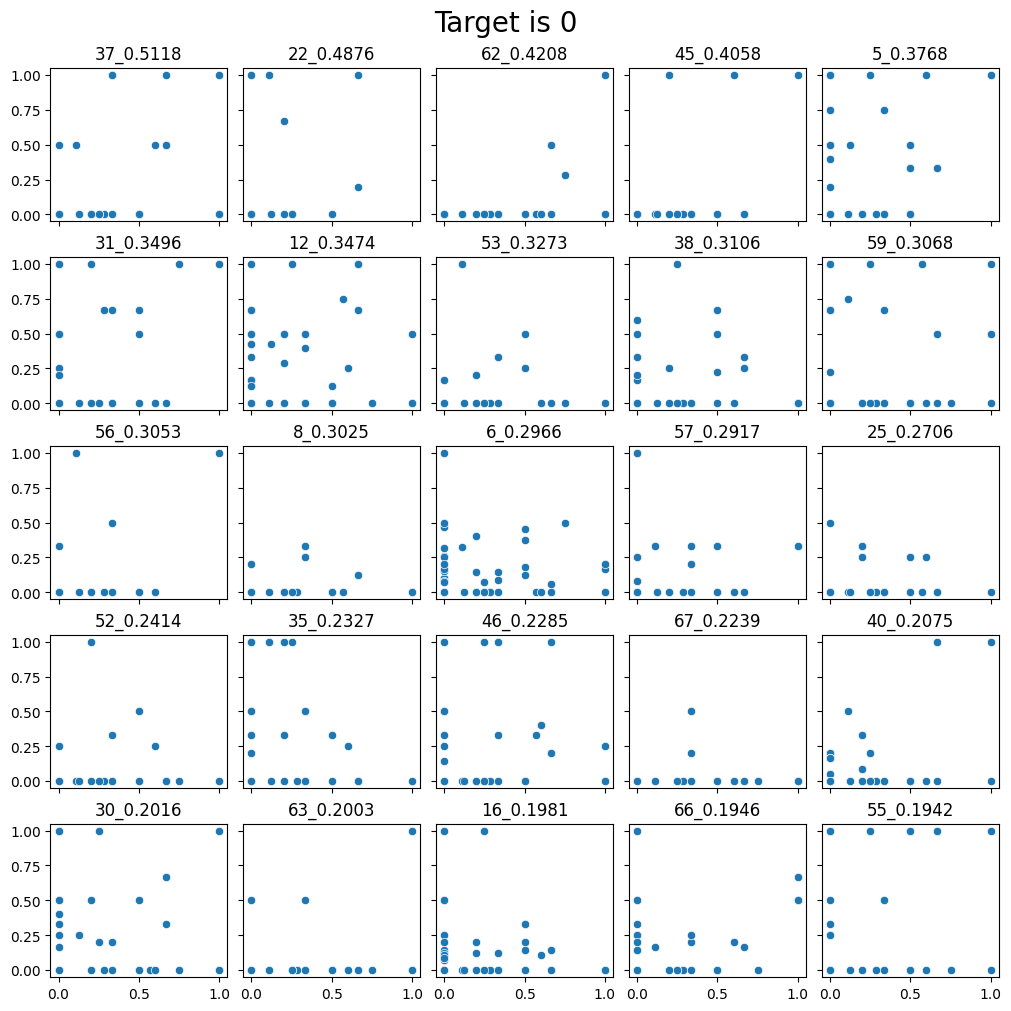

In [134]:
show_num = 5
fig, axes = plt.subplots(show_num,show_num, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)
target = 0

# tlst = [(index_, value) for index_, value in enumerate(result[0])]
# tlst.sort(key=lambda x: x[1], reverse=True)
tlst = scc_matrix[target].sort_values(ascending=False)

plt_num = 0
for index_, idx in tlst[1:show_num*show_num+1].items():
    sns.scatterplot(
        ax= axes[plt_num//show_num, plt_num%show_num],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,index_])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=index_,
    ).set(title=f"{index_}_{round(idx,4)}", ylabel=None, xlabel=None)
    plt_num += 1

fig.suptitle(f"Target is {target}", fontsize=20)